## LOADING DATA

In [1]:
import pandas as pd

# Load your file
df = pd.read_csv("/kaggle/input/beemdata/downloadnr-yvAQyma30ahKM25vVo-0-0-v3 (1).csv")

# Show first 10 rows
print(df.head(10))

       msgid            starttime      destaddr    sourceaddr  status  npdus  \
0  474505003  2023-09-01 05:06:01  255717343995         15321       3    1.0   
1  474504996  2023-09-01 05:06:01  255717343995         15321       3    1.0   
2  474568544  2023-09-01 06:06:01  255789778987         15321       1    1.0   
3  474568553  2023-09-01 06:06:01  255789778987         15321       1    1.0   
4  474593490  2023-09-01 06:33:23         15321  255788442731      11    1.0   
5  474595391  2023-09-01 06:36:01  255754047826         15321       1    1.0   
6  474595386  2023-09-01 06:36:01  255754047826         15321       1    1.0   
7  474624162  2023-09-01 07:03:00         15321  255695325028      11    1.0   
8  474850700  2023-09-01 08:18:01  255787296542         15321       1    1.0   
9  474850704  2023-09-01 08:18:01  255754986901         15321       1    1.0   

                                       decoded_bytes  
0  7920697320667265652e20436f6e74696e75653f0a313a...  
1  48656c

/tmp/ipykernel_47/3466043779.py:4: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/kaggle/input/beemdata/downloadnr-yvAQyma30ahKM25vVo-0-0-v3 (1).csv")


## EXPLORATORY DATA ANALYSIS

In [4]:
df['sourceaddr'].value_counts()

sourceaddr
15321            233581
MomCare           11295
INFO               6466
BSMS                991
255653444544         68
                  ...  
255783368869          1
+255655277538         1
+255714370934         1
255712552490          1
255783820394          1
Name: count, Length: 6251, dtype: int64

In [5]:
df['destaddr'].value_counts()

destaddr
15321           20462
255653444544      110
255763361732      103
255754647932       96
255654509066       76
                ...  
255748194733        1
255759793188        1
255754495868        1
255755263634        1
255759943000        1
Name: count, Length: 30075, dtype: int64

In [6]:
df.isnull().sum()

msgid             0
starttime         0
destaddr          0
sourceaddr        0
status            0
npdus           775
decoded_text      0
dtype: int64

In [7]:
df.dtypes

msgid             int64
starttime        object
destaddr         object
sourceaddr       object
status            int64
npdus           float64
decoded_text     object
dtype: object

In [3]:
df['status'].value_counts()

status
1     196181
3      48180
10     14644
5       8182
11      5171
8        311
4        131
Name: count, dtype: int64

In [15]:
print(df['npdus'].value_counts())

npdus
1.0    267557
2.0      4467
3.0         1
Name: count, dtype: int64


In [5]:
import pandas as pd

# Load the file
df = pd.read_csv(
    "/kaggle/input/beemdata/downloadnr-yvAQyma30ahKM25vVo-0-0-v3 (1).csv",
    low_memory=False
)

# Decode hex column → human-readable text
df['decoded_text'] = df['decoded_bytes'].apply(
    lambda x: bytes.fromhex(str(x)).decode('utf-8', errors='replace') if pd.notna(x) else ''
)

# Clean common artifacts
df['decoded_text'] = (
    df['decoded_text']
    .str.replace('SMS repl', 'SMS reply', regex=False)
    .str.replace('\r\n', '\n')
    .str.strip()
)

# Drop raw hex
df.drop(columns=['decoded_bytes'], inplace=True)

# Normalize source addresses
df['sourceaddr_str'] = df['sourceaddr'].astype(str).str.strip()

# Identify phone-number sources: remove non-digits, check starts with 255
df['source_is_phone'] = df['sourceaddr_str'].str.replace(r'\D', '', regex=True).str.startswith('255')

# Filter only phone-number sources
df_phone_sources = df[df['source_is_phone']].copy()

# Count messages per phone number
top_sources = df_phone_sources['sourceaddr_str'].value_counts().head(20)  # top 20 sources

# Display full messages for each top source
display_cols = ['msgid', 'starttime', 'sourceaddr_str', 'destaddr', 'npdus', 'status', 'decoded_text']

for source in top_sources.index:
    print(f"\n=== Messages from {source} ({top_sources[source]} messages) ===\n")
    subset = df_phone_sources[df_phone_sources['sourceaddr_str'] == source]
    # Show all messages for this source (or limit if too many)
    print(subset[display_cols].to_string(index=False))



=== Messages from 255653444544 (68 messages) ===

     msgid           starttime sourceaddr_str destaddr  npdus  status      decoded_text
 494409186 2023-09-13 10:19:05   255653444544    15321    1.0      10                 1
 494409365 2023-09-13 10:19:16   255653444544    15321    1.0      10                10
 494408106 2023-09-13 10:17:59   255653444544    15321    1.0      10                 1
 494409591 2023-09-13 10:19:34   255653444544    15321    1.0      10      Huduma nzuri
 549177581 2023-10-17 06:48:54   255653444544    15321    1.0      10                 1
 549182134 2023-10-17 06:55:38   255653444544    15321    1.0      10                 2
 563813226 2023-10-26 08:37:57   255653444544    15321    1.0      10                 1
 563815656 2023-10-26 08:40:33   255653444544    15321    1.0      10                 2
 565097329 2023-10-27 05:21:51   255653444544    15321    1.0      10    Teller service
 573136712 2023-11-01 00:23:06   255653444544    15321    1.0       3

Invalid timestamps (NaT): 0


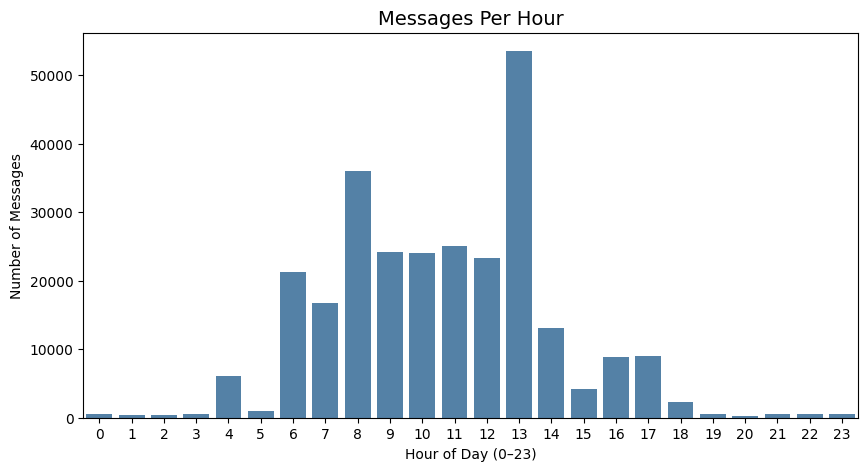

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# FIX DATETIME COLUMN
# -----------------------------
df['starttime'] = pd.to_datetime(df['starttime'], errors='coerce')

# Check how many converted
print("Invalid timestamps (NaT):", df['starttime'].isna().sum())

# -----------------------------
# EXTRACT HOUR SAFELY
# -----------------------------
df['hour'] = df['starttime'].apply(lambda x: x.hour if pd.notna(x) else None)

# -----------------------------
# PLOT: MESSAGES PER HOUR
# -----------------------------
plt.figure(figsize=(10,5))
sns.countplot(x=df['hour'], color='steelblue')
plt.title("Messages Per Hour", fontsize=14)
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Number of Messages")
plt.xticks(range(0, 24))
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


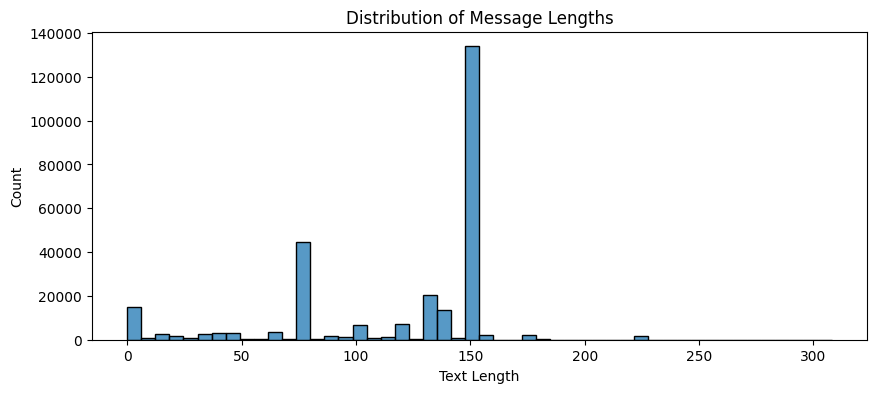

In [7]:
df['text_length'] = df['decoded_text'].str.len()

plt.figure(figsize=(10,4))
sns.histplot(df['text_length'], bins=50, kde=False)
plt.title("Distribution of Message Lengths")
plt.xlabel("Text Length")
plt.ylabel("Count")
plt.show()


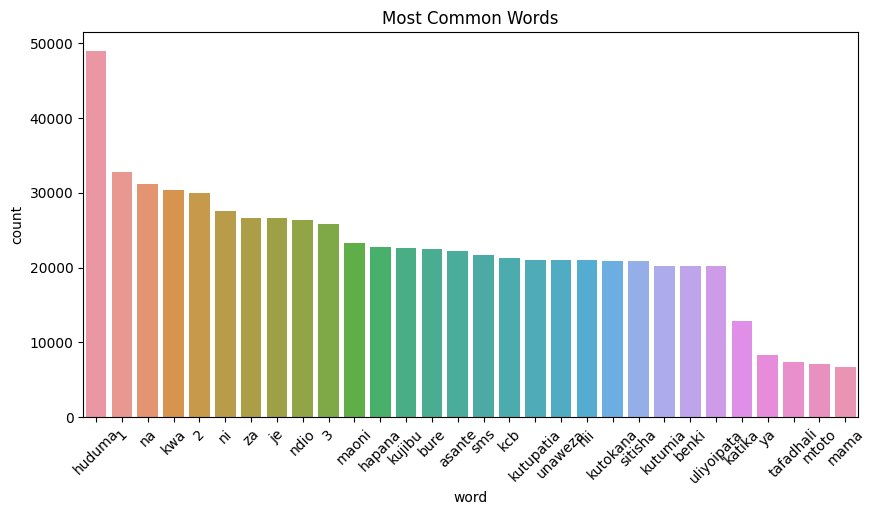

In [9]:
from collections import Counter
import re

words = Counter()

for text in df['decoded_text'].dropna().head(50000):   # only sample to save time
    tokens = re.findall(r'\b\w+\b', text.lower())
    words.update(tokens)

common_words = pd.DataFrame(words.most_common(30), columns=['word', 'count'])

plt.figure(figsize=(10,5))
sns.barplot(data=common_words, x='word', y='count')
plt.xticks(rotation=45)
plt.title("Most Common Words")
plt.show()


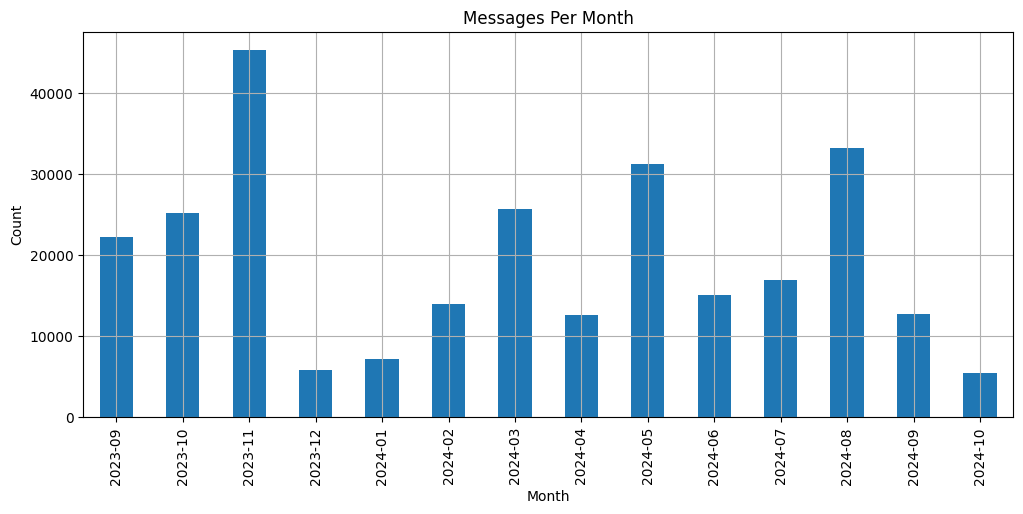

In [17]:
df['month'] = df['starttime'].dt.to_period('M')

monthly = df.groupby('month').size()

plt.figure(figsize=(12,5))
monthly.plot(kind='bar')
plt.title("Messages Per Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.grid(True)
plt.show()


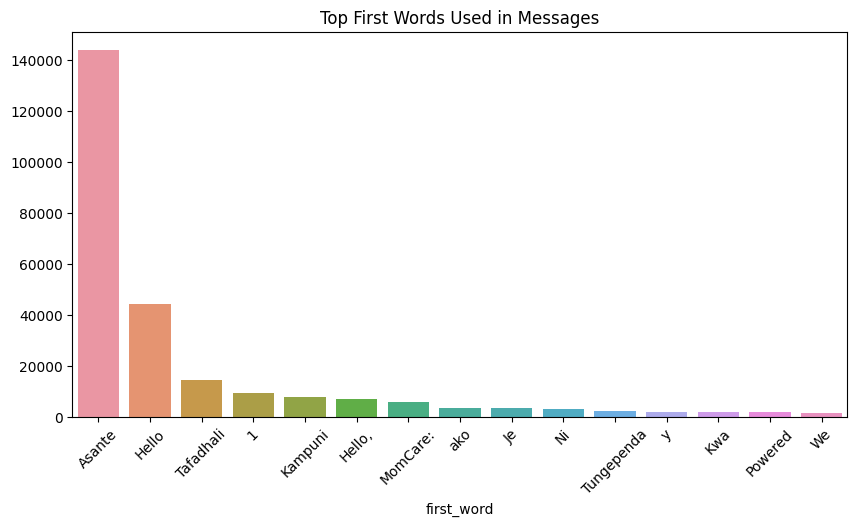

In [12]:
df['first_word'] = df['decoded_text'].str.split().str[0]

top_words = df['first_word'].value_counts().head(15)

plt.figure(figsize=(10,5))
sns.barplot(x=top_words.index, y=top_words.values)
plt.xticks(rotation=45)
plt.title("Top First Words Used in Messages")
plt.show()


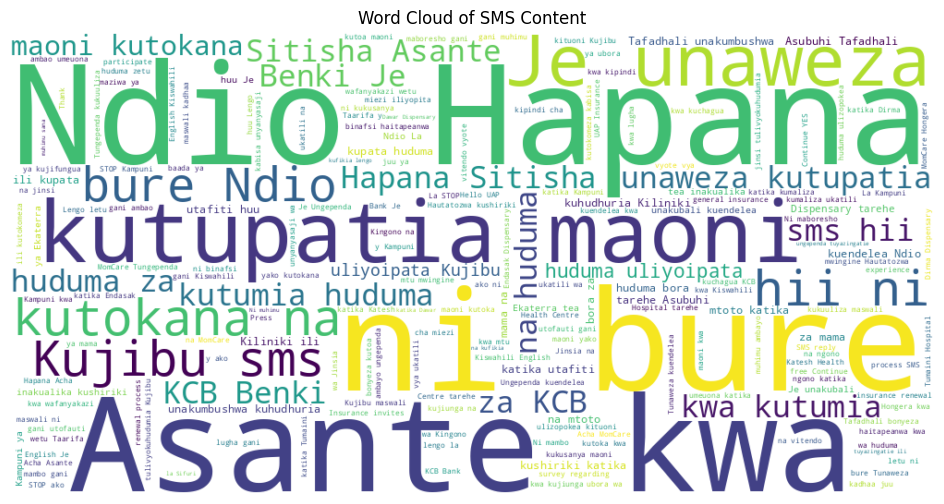

In [13]:
from wordcloud import WordCloud

all_text = " ".join(df['decoded_text'].dropna().head(50000))

wc = WordCloud(width=1000, height=500, background_color='white').generate(all_text)

plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of SMS Content")
plt.show()


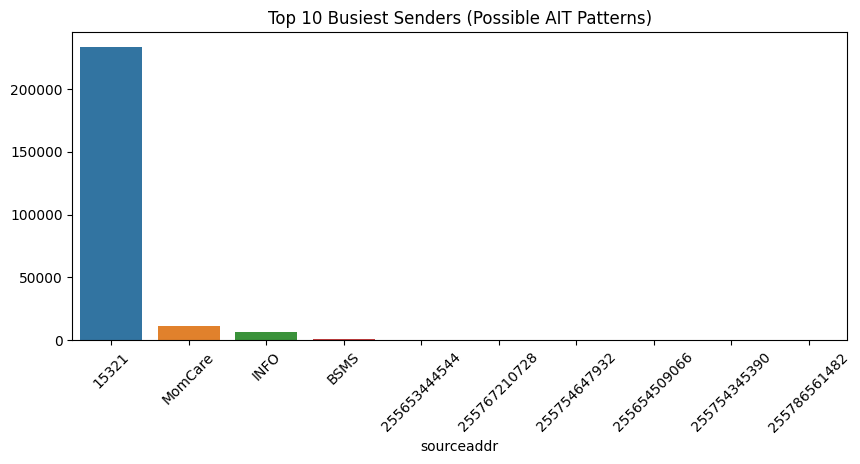

In [14]:
source_volume = df['sourceaddr'].value_counts().head(10)

plt.figure(figsize=(10,4))
sns.barplot(x=source_volume.index.astype(str), y=source_volume.values)
plt.title("Top 10 Busiest Senders (Possible AIT Patterns)")
plt.xticks(rotation=45)
plt.show()


## LABELLING REAL DATA

In [3]:
import pandas as pd

# Load file
df = pd.read_csv(
    "/kaggle/input/beemdata/downloadnr-yvAQyma30ahKM25vVo-0-0-v3 (1).csv",
    low_memory=False
)

# Decode hex → readable text
df['decoded_text'] = df['decoded_bytes'].apply(
    lambda x: bytes.fromhex(str(x)).decode('utf-8', errors='replace')
    if pd.notna(x) else ''
)

# Light cleaning
df['decoded_text'] = (
    df['decoded_text']
    .str.replace('SMS repl', 'SMS reply', regex=False)
    .str.replace('\r\n', '\n')
    .str.strip()
)

# Drop raw bytes
df = df.drop(columns=['decoded_bytes'])

# -------------------------
# 👉 ADD LABEL COLUMN = 0
# -------------------------
df['label'] = 0  # 0 = normal traffic

# Print few sample rows
print(df[['msgid', 'starttime', 'destaddr', 'sourceaddr', 'status', 'npdus', 'decoded_text']].head(20))

# Save labelled normal dataset
df.to_csv("/kaggle/working/normal_labeled.csv", index=False)

print("Done! Normal dataset saved as normal_labeled.csv")


        msgid            starttime      destaddr    sourceaddr  status  npdus  \
0   474505003  2023-09-01 05:06:01  255717343995         15321       3    1.0   
1   474504996  2023-09-01 05:06:01  255717343995         15321       3    1.0   
2   474568544  2023-09-01 06:06:01  255789778987         15321       1    1.0   
3   474568553  2023-09-01 06:06:01  255789778987         15321       1    1.0   
4   474593490  2023-09-01 06:33:23         15321  255788442731      11    1.0   
5   474595391  2023-09-01 06:36:01  255754047826         15321       1    1.0   
6   474595386  2023-09-01 06:36:01  255754047826         15321       1    1.0   
7   474624162  2023-09-01 07:03:00         15321  255695325028      11    1.0   
8   474850700  2023-09-01 08:18:01  255787296542         15321       1    1.0   
9   474850704  2023-09-01 08:18:01  255754986901         15321       1    1.0   
10  474878110  2023-09-01 08:36:01  255769404229         15321       1    1.0   
11  474878112  2023-09-01 08

## GENERATING AIT

In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime

# -----------------------------
# Reproducibility
# -----------------------------
random.seed(42)
np.random.seed(42)

# -----------------------------
# Load NORMAL data
# -----------------------------
normal_path = "/kaggle/input/normal-data/normal_labeled.csv"
df_normal = pd.read_csv(normal_path)

# Keep only usable rows
df_normal = df_normal.dropna(subset=["decoded_text", "sourceaddr", "status", "npdus"])
df_normal["decoded_text"] = df_normal["decoded_text"].astype(str)
df_normal["sourceaddr"] = df_normal["sourceaddr"].astype(str)

# -----------------------------
# Parameters
# -----------------------------
N = int(0.10 * len(df_normal))   # 10% of normal data
burst_sources = ["15321", "INFO", "MomCare", "BSMS"]

print(f"Generating {N} HARD AIT samples (10% of normal data)")

# -----------------------------
# Build SOURCE → MESSAGE pools
# -----------------------------
sid_message_map = (
    df_normal.groupby("sourceaddr")["decoded_text"]
    .apply(list).to_dict()
)

sid_short_replies = (
    df_normal[df_normal["decoded_text"].str.len() <= 5]
    .groupby("sourceaddr")["decoded_text"]
    .apply(list).to_dict()
)

# -----------------------------
# Source → status distribution
# -----------------------------
source_status_map = (
    df_normal.groupby("sourceaddr")["status"]
    .apply(lambda x: x.value_counts(normalize=True).to_dict())
    .to_dict()
)

# -----------------------------
# Source → npdus distribution
# -----------------------------
source_npdus_map = (
    df_normal.groupby("sourceaddr")["npdus"]
    .apply(lambda x: x.value_counts(normalize=True).to_dict())
    .to_dict()
)

# -----------------------------
# Fix ONE dominant message per source (true AIT)
# -----------------------------
source_fixed_message = {}
for s in burst_sources:
    if s in sid_message_map:
        source_fixed_message[s] = random.choice(sid_message_map[s])

# -----------------------------
# Destination patterns
# -----------------------------
def gen_msisdn():
    return "255" + str(random.randint(600000000, 799999999))

sequential_blocks = [
    [str(255600000000 + i) for i in range(300)],
    [str(255601000000 + i) for i in range(200)],
]

# -----------------------------
# Determine msgid gaps
# -----------------------------
existing_msgids = sorted(df_normal["msgid"].unique())
gaps = []
for i in range(len(existing_msgids) - 1):
    start = existing_msgids[i] + 1
    end = existing_msgids[i + 1]
    if end - start > 0:
        gaps.extend(range(start, end))

# -----------------------------
# msgid generator
# -----------------------------
msgid_pool = gaps[:N]  # Fill from gaps first
remaining = N - len(msgid_pool)
if remaining > 0:
    msgid_pool.extend(range(existing_msgids[-1] + 1, existing_msgids[-1] + 1 + remaining))

# Shuffle to avoid perfect sequential assignment (optional)
# random.shuffle(msgid_pool)

# -----------------------------
# Generate HARD AIT
# -----------------------------
rows = []

for i in range(N):
    source = random.choice(burst_sources)

    # Abnormal timing (night bursts)
    if random.random() < 0.8:
        hour = random.choice([0, 1, 2, 3, 4, 22, 23])
    else:
        hour = random.randint(9, 17)

    ts = datetime(
        2023, 9,
        random.randint(1, 30),
        hour,
        random.randint(0, 59),
        random.randint(0, 59)
    )

    # Destination behavior
    if random.random() < 0.6:
        dest = random.choice(random.choice(sequential_blocks))
    else:
        dest = gen_msisdn()

    # -----------------------------
    # Content generation (SEMANTICALLY CONSISTENT)
    # -----------------------------
    if random.random() < 0.7 and source in source_fixed_message:
        text = source_fixed_message[source]
    elif source in sid_short_replies and random.random() < 0.5:
        text = random.choice(sid_short_replies[source])
    else:
        text = random.choice(sid_message_map[source])

    # -----------------------------
    # Status and npdus based on source
    # -----------------------------
    status_probs = source_status_map.get(source, {1: 0.8, 3: 0.15, 11: 0.05})
    status = random.choices(list(status_probs.keys()), weights=list(status_probs.values()))[0]

    npdus_probs = source_npdus_map.get(source, {1: 0.95, 2: 0.05})
    npdus = random.choices(list(npdus_probs.keys()), weights=list(npdus_probs.values()))[0]

    rows.append({
        "msgid": msgid_pool[i],
        "starttime": ts.strftime("%Y-%m-%d %H:%M:%S"),
        "sourceaddr": source,
        "destaddr": dest,
        "status": status,
        "npdus": npdus,
        "decoded_text": text,
        "label": 1
    })

# -----------------------------
# Build DataFrame
# -----------------------------
df_ait_hard = pd.DataFrame(rows)
df_ait_hard = df_ait_hard.sample(frac=1, random_state=42).reset_index(drop=True)

# -----------------------------
# Save
# -----------------------------
out_path = "/kaggle/working/ait_generated_10pct_hard_realistic.csv"
df_ait_hard.to_csv(out_path, index=False)

print("Saved HARD AIT dataset:", out_path)
print("Shape:", df_ait_hard.shape)
print("\nSample rows:\n")
print(df_ait_hard.head(20).to_string(index=False))


/tmp/ipykernel_47/3255109493.py:16: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_normal = pd.read_csv(normal_path)


Generating 27199 HARD AIT samples (10% of normal data)
Saved HARD AIT dataset: /kaggle/working/ait_generated_10pct_hard_realistic.csv
Shape: (27199, 8)

Sample rows:

    msgid           starttime sourceaddr     destaddr  status  npdus                                                                                                                                                                        decoded_text  label
474513920 2023-09-21 23:54:32      15321 255600000031       1      1 Hello, UAP Insurance invites you to participate in a survey regarding your experience with general insurance renewal process. SMS replyy is free. Continue?\n1: YES\n2: NO\n3: STOP      1
474530532 2023-09-21 22:08:07      15321 255693021445       1      1 Hello, UAP Insurance invites you to participate in a survey regarding your experience with general insurance renewal process. SMS replyy is free. Continue?\n1: YES\n2: NO\n3: STOP      1
474526343 2023-09-26 02:14:13    MomCare 255703193118       1    

## COMBINING BOTH (NORMAL DATA AND AIT)

In [2]:
import pandas as pd
import numpy as np

# -----------------------------
# 1. Load datasets
# -----------------------------
normal_path = "/kaggle/input/normal-data/normal_labeled.csv"
ait_path    = "/kaggle/input/ait-generated/ait_generated_10pct_hard_realistic.csv"

df_normal = pd.read_csv(normal_path)
df_ait    = pd.read_csv(ait_path)

print("Normal sample:")
print(df_normal.head(20).to_string(index=False))

print("\nAIT sample:")
print(df_ait.head(20).to_string(index=False))

print("\nShapes:")
print("Normal:", df_normal.shape)
print("AIT:", df_ait.shape)

# -----------------------------
# 2. Ensure correct label format
# -----------------------------
df_normal["label"] = 0
df_ait["label"] = 1

# -----------------------------
# 3. Standardize column names
# -----------------------------
common_cols = [
    "msgid", "starttime", "sourceaddr", "destaddr",
    "status", "npdus", "decoded_text", "label"
]

df_normal = df_normal[common_cols]
df_ait    = df_ait[common_cols]

# -----------------------------
# 4. Combine datasets
# -----------------------------
df_all = pd.concat([df_normal, df_ait], ignore_index=True)

print("\nCombined shape:", df_all.shape)
print("\nLabel distribution:")
print(df_all["label"].value_counts())

# -----------------------------
# 5. Save combined dataset
# -----------------------------
out_path = "/kaggle/working/combined_sms_dataset.csv"
df_all.to_csv(out_path, index=False)

print("\nSaved combined dataset to:", out_path)


/tmp/ipykernel_47/2702221608.py:10: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_normal = pd.read_csv(normal_path)


Normal sample:
    msgid           starttime     destaddr   sourceaddr  status  npdus                                                                                                                            decoded_text  label
474505003 2023-09-01 05:06:01 255717343995        15321       3    1.0                                                                                            y is free. Continue?\n1: YES\n2: NO\n3: STOP      0
474504996 2023-09-01 05:06:01 255717343995        15321       3    1.0 Hello, UAP Insurance invites you to participate in a survey regarding your experience with general insurance renewal process. SMS reply      0
474568544 2023-09-01 06:06:01 255789778987        15321       1    1.0 Hello, UAP Insurance invites you to participate in a survey regarding your experience with general insurance renewal process. SMS reply      0
474568553 2023-09-01 06:06:01 255789778987        15321       1    1.0                                                           

## MACHINE LEARNING 

Interleaved dataset shape: (299999, 8)

Training model: Logistic Regression

Training model: Linear SVM


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Training model: Decision Tree

Training model: Random Forest

Training model: Extra Trees

Training model: Gradient Boosting

Training model: AdaBoost

Training model: XGBoost

FINAL PERFORMANCE AND LATENCY COMPARISON
              Model  Accuracy  F1-Score  Train Latency (s)  Inference Latency (s)
Logistic Regression    0.9334    0.7212            24.2811                 0.0070
         Linear SVM    0.9316    0.7164           214.5121                 0.0071
      Decision Tree    0.9983    0.9905             4.0768                 0.0430
      Random Forest    0.9941    0.9679            54.2458                 0.4205
        Extra Trees    0.9658    0.8338            70.8540                 0.4661
  Gradient Boosting    0.9989    0.9938           194.4372                 0.1824
           AdaBoost    0.9927    0.9584            85.5076                 4.1779
            XGBoost    0.9988    0.9935             5.2517                 0.1079


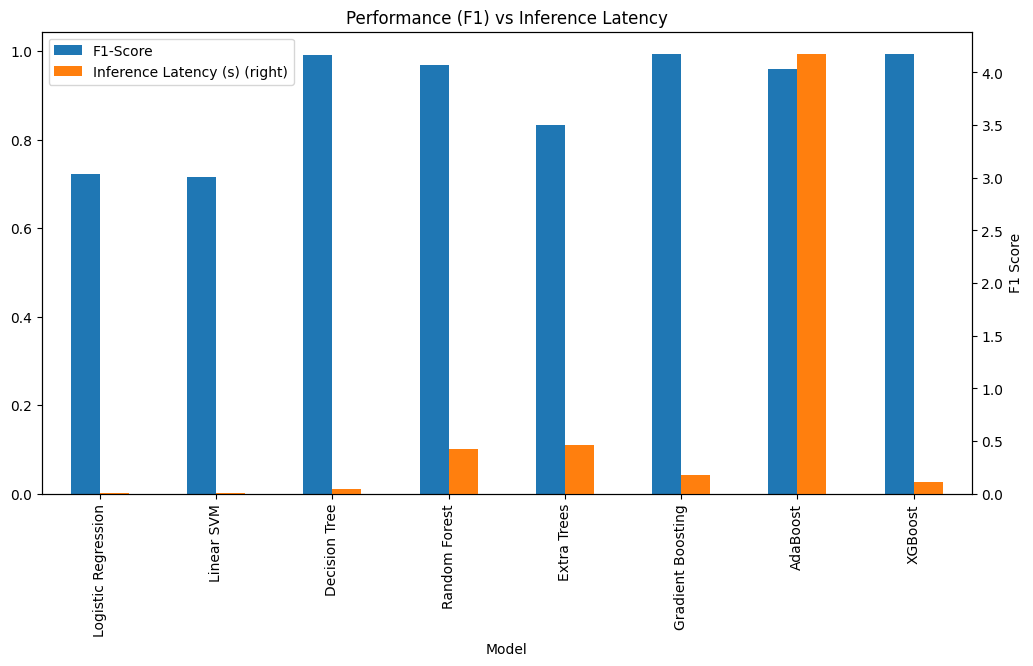

In [3]:
# ===============================================
# AIT + Normal SMS Pipeline with Latency Comparison
# ===============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import joblib
import os
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# ML models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# -----------------------------
# 1. Load datasets
# -----------------------------
normal_path = "/kaggle/input/normal-data/normal_labeled.csv"
ait_path    = "/kaggle/input/ait-generated/ait_generated_10pct_hard_realistic.csv"

# Note: Using try-except or check if files exist in your environment
df_normal = pd.read_csv(normal_path, low_memory=False)
df_ait    = pd.read_csv(ait_path, low_memory=False)

df_normal['label'] = 0
df_ait['label'] = 1

cols = ['msgid', 'starttime', 'sourceaddr', 'destaddr', 'status', 'npdus', 'decoded_text', 'label']
df_normal = df_normal[cols]
df_ait = df_ait[cols]

# -----------------------------
# 2. Realistic interleaving
# -----------------------------
df_normal['starttime'] = pd.to_datetime(df_normal['starttime'])
df_ait['starttime'] = pd.to_datetime(df_ait['starttime'])

min_time = df_normal['starttime'].min()
max_time = df_normal['starttime'].max()
time_span = (max_time - min_time).total_seconds()

np.random.seed(42)
df_ait['starttime'] = df_ait['starttime'].apply(
    lambda x: min_time + pd.to_timedelta(np.random.uniform(0, time_span), unit='s')
)

df_all = pd.concat([df_normal, df_ait], ignore_index=True)
df_all.sort_values(by='starttime', inplace=True)
df_all.reset_index(drop=True, inplace=True)
print("Interleaved dataset shape:", df_all.shape)

# -----------------------------
# 3. Feature Engineering
# -----------------------------
df_all['decoded_text'] = df_all['decoded_text'].fillna('').astype(str)
df_all['msg_len'] = df_all['decoded_text'].str.len()
df_all['digit_ratio'] = df_all['decoded_text'].apply(lambda s: sum(c.isdigit() for c in s)/max(len(s),1))
df_all['unique_chars'] = df_all['decoded_text'].apply(lambda s: len(set(s)))
df_all['msg_count_global'] = df_all['decoded_text'].map(df_all['decoded_text'].value_counts())
df_all['hour'] = df_all['starttime'].dt.hour
df_all['is_midnight'] = df_all['hour'].apply(lambda h: 1 if h>=22 or h<=4 else 0)
df_all['src_count'] = df_all['sourceaddr'].map(df_all['sourceaddr'].value_counts())
df_all['dst_count'] = df_all['destaddr'].map(df_all['destaddr'].value_counts())
df_all['dest_prefix'] = df_all['destaddr'].astype(str).str[:6]
df_all['dest_prefix_count'] = df_all['dest_prefix'].map(df_all['dest_prefix'].value_counts())
df_all['npdus'] = pd.to_numeric(df_all['npdus'], errors='coerce').fillna(1)
df_all['status'] = pd.to_numeric(df_all['status'], errors='coerce').fillna(0)

per_src_msg = df_all.groupby(['sourceaddr','decoded_text']).size().rename('count').reset_index()
df_all = df_all.merge(per_src_msg, on=['sourceaddr','decoded_text'], how='left')
df_all['per_src_msg_count'] = df_all['count']
src_total = df_all.groupby('sourceaddr').size().rename('src_total').reset_index()
df_all = df_all.merge(src_total, on='sourceaddr', how='left')
df_all['per_src_msg_ratio'] = df_all['per_src_msg_count']/df_all['src_total']
df_all.drop(columns=['count','src_total','dest_prefix'], inplace=True)

# -----------------------------
# 4. Prepare Features
# -----------------------------
tfidf = TfidfVectorizer(min_df=3, max_df=0.95, ngram_range=(1,2), sublinear_tf=True)
X_text = tfidf.fit_transform(df_all['decoded_text'])

num_features = ['msg_len','digit_ratio','unique_chars','msg_count_global',
                'hour','is_midnight','src_count','dst_count','dest_prefix_count',
                'npdus','status','per_src_msg_count','per_src_msg_ratio']

X_num = csr_matrix(StandardScaler().fit_transform(df_all[num_features]))
X = hstack([X_text, X_num], format='csr')
y = df_all['label'].values

# -----------------------------
# 5. Train/Test Split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scale_pos_weight = max(1.0, sum(y_train==0)/sum(y_train==1))

# -----------------------------
# 6. Define ML models
# -----------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced", n_jobs=-1),
    "Linear SVM": LinearSVC(class_weight="balanced", max_iter=2000),
    "Decision Tree": DecisionTreeClassifier(max_depth=20, class_weight="balanced", random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=20, class_weight="balanced", n_jobs=-1, random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, max_depth=20, class_weight="balanced", n_jobs=-1, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, eval_metric="logloss",
                             scale_pos_weight=scale_pos_weight, random_state=42)
}

# -----------------------------
# 7. Train & Evaluate with Latency
# -----------------------------
os.makedirs("/kaggle/working/model_outputs", exist_ok=True)
performance_metrics = []

for name, model in models.items():
    print(f"\nTraining model: {name}")
    
    # Prepare data for models that don't support sparse matrices (like GaussianNB)
    current_X_train = X_train
    current_X_test = X_test
    if name == "Naive Bayes":
        # GaussianNB requires dense arrays; using a subset or cautioning on memory
        current_X_train = X_train.toarray()
        current_X_test = X_test.toarray()

    # Measure Training Latency
    start_train = time.time()
    model.fit(current_X_train, y_train)
    end_train = time.time()
    train_latency = end_train - start_train

    # Measure Inference Latency
    start_infer = time.time()
    y_pred = model.predict(current_X_test)
    end_infer = time.time()
    infer_latency = end_infer - start_infer

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Log results
    performance_metrics.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "F1-Score": round(f1, 4),
        "Train Latency (s)": round(train_latency, 4),
        "Inference Latency (s)": round(infer_latency, 4)
    })
    
    # Save model
    joblib.dump(model, f"/kaggle/working/model_outputs/{name.lower().replace(' ', '_')}_ait_model.joblib")

# -----------------------------
# 8. Final Results Table
# -----------------------------
results_df = pd.DataFrame(performance_metrics)
print("\n" + "="*60)
print("FINAL PERFORMANCE AND LATENCY COMPARISON")
print("="*60)
print(results_df.to_string(index=False))
print("="*60)

# Optional: Visualize Latency vs Performance
results_df.set_index('Model')[['F1-Score', 'Inference Latency (s)']].plot(kind='bar', secondary_y='Inference Latency (s)', figsize=(12,6))
plt.title("Performance (F1) vs Inference Latency")
plt.ylabel("F1 Score")
plt.show()

## DEEP LEARNING

In [4]:
pip install torch torchvision torchaudio tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 22.4 MB/s eta 0:00:00
  Attempting uninstall:

In [1]:
# ===============================================
# Hybrid Deep Learning: Text + Numeric Features
# ===============================================
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Conv1D, LSTM, GlobalAveragePooling1D,
    GlobalMaxPooling1D, Dropout, Concatenate, TextVectorization, Embedding
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
import time
import gc

# -----------------------------
# 0. GPU Cleanup
# -----------------------------
tf.keras.backend.clear_session()
gc.collect()

# -----------------------------
# 1. Load datasets
# -----------------------------
normal_path = "/kaggle/input/normal-data/normal_labeled.csv"
ait_path = "/kaggle/input/ait-generated/ait_generated_10pct_hard_realistic.csv"

df_normal = pd.read_csv(normal_path, low_memory=False)
df_ait = pd.read_csv(ait_path, low_memory=False)

# Labels
df_normal['label'] = 0
df_ait['label'] = 1

# Columns to keep
cols = ['msgid', 'starttime', 'sourceaddr', 'destaddr', 'status', 'npdus', 'decoded_text', 'label']
df_normal = df_normal[cols]
df_ait = df_ait[cols]

# -----------------------------
# 2. Realistic interleaving
# -----------------------------
df_normal['starttime'] = pd.to_datetime(df_normal['starttime'])
df_ait['starttime'] = pd.to_datetime(df_ait['starttime'])

# Randomize AIT timestamps within normal time span
min_time = df_normal['starttime'].min()
max_time = df_normal['starttime'].max()
time_span = (max_time - min_time).total_seconds()
np.random.seed(42)
df_ait['starttime'] = df_ait['starttime'].apply(
    lambda x: min_time + pd.to_timedelta(np.random.uniform(0, time_span), unit='s')
)

# Combine and sort
df_all = pd.concat([df_normal, df_ait], ignore_index=True)
df_all.sort_values(by='starttime', inplace=True)
df_all.reset_index(drop=True, inplace=True)
print("Interleaved dataset shape:", df_all.shape)

# -----------------------------
# 3. Feature Engineering
# -----------------------------
df_all['decoded_text'] = df_all['decoded_text'].fillna('').astype(str)

# Numeric features
df_all['msg_len'] = df_all['decoded_text'].str.len()
df_all['digit_ratio'] = df_all['decoded_text'].apply(lambda s: sum(c.isdigit() for c in s)/max(len(s),1))
df_all['unique_chars'] = df_all['decoded_text'].apply(lambda s: len(set(s)))
df_all['msg_count_global'] = df_all['decoded_text'].map(df_all['decoded_text'].value_counts())
df_all['hour'] = df_all['starttime'].dt.hour
df_all['is_midnight'] = df_all['hour'].apply(lambda h: 1 if h>=22 or h<=4 else 0)
df_all['src_count'] = df_all['sourceaddr'].map(df_all['sourceaddr'].value_counts())
df_all['dst_count'] = df_all['destaddr'].map(df_all['destaddr'].value_counts())
df_all['dest_prefix'] = df_all['destaddr'].astype(str).str[:6]
df_all['dest_prefix_count'] = df_all['dest_prefix'].map(df_all['dest_prefix'].value_counts())
df_all['npdus'] = pd.to_numeric(df_all['npdus'], errors='coerce').fillna(1)
df_all['status'] = pd.to_numeric(df_all['status'], errors='coerce').fillna(0)

# per-source message count & ratio
per_src_msg = df_all.groupby(['sourceaddr','decoded_text']).size().rename('count').reset_index()
df_all = df_all.merge(per_src_msg, on=['sourceaddr','decoded_text'], how='left')
df_all['per_src_msg_count'] = df_all['count']
src_total = df_all.groupby('sourceaddr').size().rename('src_total').reset_index()
df_all = df_all.merge(src_total, on='sourceaddr', how='left')
df_all['per_src_msg_ratio'] = df_all['per_src_msg_count']/df_all['src_total']
df_all.drop(columns=['count','src_total','dest_prefix'], inplace=True)

# -----------------------------
# 4. Prepare Features for Keras
# -----------------------------
num_features = ['msg_len','digit_ratio','unique_chars','msg_count_global',
                'hour','is_midnight','src_count','dst_count','dest_prefix_count',
                'npdus','status','per_src_msg_count','per_src_msg_ratio']

X_num = df_all[num_features].astype(np.float32).values
X_text = df_all['decoded_text'].values
y = df_all['label'].values

X_train_num, X_test_num, X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_num, X_text, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------
# 5. Text Vectorization
# -----------------------------
max_tokens = 5000
max_len = 64
text_vectorizer = TextVectorization(max_tokens=max_tokens, output_sequence_length=max_len)
text_vectorizer.adapt(X_train_text)

# -----------------------------
# 6. Hybrid Model Builder
# -----------------------------
def build_hybrid_model(model_type="MLP"):
    text_input = Input(shape=(), dtype=tf.string, name="text_input")
    t = text_vectorizer(text_input)
    t = Embedding(max_tokens, 32)(t)
    if model_type == "CNN":
        t = Conv1D(64, 3, activation='relu')(t)
        t = GlobalMaxPooling1D()(t)
    elif model_type == "LSTM":
        t = LSTM(64)(t)
    else:
        t = GlobalAveragePooling1D()(t)
        t = Dense(64, activation='relu')(t)

    num_input = Input(shape=(len(num_features),), name="num_input")
    n = Dense(32, activation='relu')(num_input)

    merged = Concatenate()([t, n])
    z = Dense(64, activation='relu')(merged)
    z = Dropout(0.3)(z)
    output = Dense(1, activation='sigmoid')(z)

    model = Model(inputs=[text_input, num_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# -----------------------------
# 7. Train & Evaluate
# -----------------------------
results = []
architectures = ["MLP", "CNN", "LSTM"]

for arch in architectures:
    print(f"\n--- Training Hybrid {arch} ---")
    model = build_hybrid_model(model_type=arch)

    # Use TensorFlow Dataset to avoid graph errors
    train_ds = tf.data.Dataset.from_tensor_slices(
        ({"text_input": X_train_text, "num_input": X_train_num}, y_train)
    ).batch(64).prefetch(tf.data.AUTOTUNE)

    test_ds = tf.data.Dataset.from_tensor_slices(
        ({"text_input": X_test_text, "num_input": X_test_num}, y_test)
    ).batch(64).prefetch(tf.data.AUTOTUNE)

    # Train model
    model.fit(train_ds, epochs=10, verbose=0)

    # Inference latency per sample
    start_time = time.time()
    preds_probs = model.predict(test_ds, verbose=0)
    avg_latency_ms = ((time.time() - start_time) / len(X_test_text)) * 1000

    preds = (preds_probs > 0.5).astype(int)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)

    results.append({
        "Model": arch,
        "Accuracy": round(acc, 4),
        "F1-Score": round(f1, 4),
        "Latency (ms/sample)": round(avg_latency_ms, 2)
    })

# -----------------------------
# 8. Display Results
# -----------------------------
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("FINAL HYBRID PERFORMANCE (TEXT + NUM FEATURES)")
print("="*60)
print(results_df.to_string(index=False))
print("="*60)


2025-12-22 14:10:55.411683: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766412655.620905      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766412655.676027      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Interleaved dataset shape: (299999, 8)


I0000 00:00:1766412675.916073      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



--- Training Hybrid MLP ---

--- Training Hybrid CNN ---


I0000 00:00:1766412858.951144     107 cuda_dnn.cc:529] Loaded cuDNN version 90300



--- Training Hybrid LSTM ---

FINAL HYBRID PERFORMANCE (TEXT + NUM FEATURES)
Model  Accuracy  F1-Score  Latency (ms/sample)
  MLP    0.9595    0.7123                 0.04
  CNN    0.9610    0.7304                 0.04
 LSTM    0.9093    0.0000                 0.06


In [9]:
# Display the first 30 rows to check interleaving
df_all[['msgid', 'starttime','sourceaddr', 'destaddr','label','status','npdus','decoded_text']].head(30)


,msgid,starttime,sourceaddr,destaddr,label,status,npdus,decoded_text
0,474505003,2023-09-01 05:06:01.000000000,15321,255717343995,0,3,1.0,y is free. Continue?\n1: YES\n2: NO\n3: STOP
1,474504996,2023-09-01 05:06:01.000000000,15321,255717343995,0,3,1.0,"Hello, UAP Insurance invites you to participat..."
2,474518430,2023-09-01 05:12:46.560370006,15321,255732245144,1,11,1.0,"Hello, UAP Insurance invites you to participat..."
3,474514680,2023-09-01 05:23:51.787129371,MomCare,255637897914,1,1,1.0,Tafadhali unakumbushwa kuhudhuria Kiliniki ili...
4,474517451,2023-09-01 05:33:58.486442043,INFO,255687640291,1,1,1.0,Asante kwa kutumia huduma za KCB Benki. Je una...
5,474519929,2023-09-01 05:36:42.423350499,MomCare,255600000293,1,11,1.0,Tafadhali unakumbushwa kuhudhuria Kiliniki ili...
6,474568544,2023-09-01 06:06:01.000000000,15321,255789778987,0,1,1.0,"Hello, UAP Insurance invites you to participat..."
7,474568553,2023-09-01 06:06:01.000000000,15321,255789778987,0,1,1.0,y is free. Continue?\n1: YES\n2: NO\n3: STOP
8,474510413,2023-09-01 06:10:03.422889578,15321,255707155871,1,1,1.0,"Hello, UAP Insurance invites you to participat..."
9,474507817,2023-09-01 06:24:16.083224114,15321,255600000003,1,3,1.0,"Hello, UAP Insurance invites you to participat..."


In [10]:
df_all[['msgid', 'starttime','sourceaddr', 'destaddr','label','status','npdus','decoded_text']].tail(30)

,msgid,starttime,sourceaddr,destaddr,label,status,npdus,decoded_text
299969,1184700017,2024-10-08 12:32:49.000000000,15321,255769470721,0,1,1.0,Asante kwa kutumia huduma za KCB Benk. Je unaw...
299970,1184700131,2024-10-08 12:32:50.000000000,15321,255712221852,0,10,1.0,Asante kwa kutumia huduma za KCB Benk. Je unaw...
299971,1184700167,2024-10-08 12:32:50.000000000,15321,255784529704,0,1,1.0,Asante kwa kutumia huduma za KCB Benk. Je unaw...
299972,1184700319,2024-10-08 12:32:51.000000000,15321,255777044645,0,10,1.0,Asante kwa kutumia huduma za KCB Benk. Je unaw...
299973,1184700359,2024-10-08 12:32:52.000000000,15321,255717373658,0,1,1.0,Asante kwa kutumia huduma za KCB Benk. Je unaw...
299974,1184700378,2024-10-08 12:32:52.000000000,15321,255712049352,0,1,1.0,Asante kwa kutumia huduma za KCB Benk. Je unaw...
299975,1184700399,2024-10-08 12:32:52.000000000,15321,255654629344,0,1,1.0,Asante kwa kutumia huduma za KCB Benk. Je unaw...
299976,1184700436,2024-10-08 12:32:53.000000000,15321,255624030010,0,1,1.0,Asante kwa kutumia huduma za KCB Benk. Je unaw...
299977,1184700414,2024-10-08 12:32:53.000000000,15321,255714251707,0,1,1.0,Asante kwa kutumia huduma za KCB Benk. Je unaw...
299978,1184700460,2024-10-08 12:32:53.000000000,15321,255766275223,0,1,1.0,Asante kwa kutumia huduma za KCB Benk. Je unaw...


In [16]:
print(df_all['status'].value_counts())
print(df_all['npdus'].value_counts())

status
1     202797
3      54996
10     14644
11     11739
5       8182
8        311
4        131
Name: count, dtype: int64
npdus
1.0    284287
2.0      7474
3.0      1039
Name: count, dtype: int64


## IMPACT OF CLASS IMBALANCE ON PERFORMANCE

In [1]:
# ===============================================================
# AIT Proportion Experiment: 8 Models, 13 Numerical Features
# ===============================================================
import pandas as pd
import numpy as np
import time
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix
from sklearn.metrics import accuracy_score, f1_score

# ML models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

# 1. Load datasets
normal_path = "/kaggle/input/normal-data/normal_labeled.csv"
ait_path    = "/kaggle/input/ait-generated/ait_generated_10pct_hard_realistic.csv"

df_normal_raw = pd.read_csv(normal_path, low_memory=False)
df_ait_raw    = pd.read_csv(ait_path, low_memory=False)

df_normal_raw['label'] = 0
df_ait_raw['label'] = 1

cols = ['msgid', 'starttime', 'sourceaddr', 'destaddr', 'status', 'npdus', 'decoded_text', 'label']
df_normal_raw = df_normal_raw[cols].dropna(subset=['decoded_text'])
df_ait_raw    = df_ait_raw[cols].dropna(subset=['decoded_text'])

# Define proportions of the AIT dataset to take
ait_proportions = [0.01, 0.05, 0.10, 0.25, 0.50, 0.75]
all_results = []

for prop in ait_proportions:
    # --- Sample Verification ---
    df_ait_sampled = df_ait_raw.sample(frac=prop, random_state=42)
    df_all = pd.concat([df_normal_raw, df_ait_sampled], ignore_index=True)
    
    print(f"\n{'='*70}")
    print(f"RUNNING EXPERIMENT: AIT PROPORTION {prop*100}%")
    print(f"Counts -> Normal: {len(df_normal_raw)} | AIT: {len(df_ait_sampled)} | Total: {len(df_all)}")
    print("-" * 70)
    print("MIXED DATA PREVIEW (TOP 5):")
    print(df_all[['sourceaddr', 'label', 'decoded_text']].head())
    print(f"{'='*70}")

    # 2. Feature Engineering (The full 13-feature set)
    df_all['decoded_text'] = df_all['decoded_text'].fillna('').astype(str)
    df_all['msg_len'] = df_all['decoded_text'].str.len()
    df_all['digit_ratio'] = df_all['decoded_text'].apply(lambda s: sum(c.isdigit() for c in s)/max(len(s),1))
    df_all['unique_chars'] = df_all['decoded_text'].apply(lambda s: len(set(s)))
    df_all['msg_count_global'] = df_all['decoded_text'].map(df_all['decoded_text'].value_counts())
    
    df_all['starttime'] = pd.to_datetime(df_all['starttime'])
    df_all['hour'] = df_all['starttime'].dt.hour
    df_all['is_midnight'] = df_all['hour'].apply(lambda h: 1 if h>=22 or h<=4 else 0)
    
    df_all['src_count'] = df_all['sourceaddr'].map(df_all['sourceaddr'].value_counts())
    df_all['dst_count'] = df_all['destaddr'].map(df_all['destaddr'].value_counts())
    
    # Destination Prefix logic
    df_all['dest_prefix'] = df_all['destaddr'].astype(str).str[:6]
    df_all['dest_prefix_count'] = df_all['dest_prefix'].map(df_all['dest_prefix'].value_counts())
    
    # Numeric conversion for status/npdus
    df_all['npdus'] = pd.to_numeric(df_all['npdus'], errors='coerce').fillna(1)
    df_all['status'] = pd.to_numeric(df_all['status'], errors='coerce').fillna(0)

    # Per-source msg logic
    per_src_msg = df_all.groupby(['sourceaddr','decoded_text']).size().rename('count').reset_index()
    df_all = df_all.merge(per_src_msg, on=['sourceaddr','decoded_text'], how='left')
    df_all['per_src_msg_count'] = df_all['count']
    
    src_total = df_all.groupby('sourceaddr').size().rename('src_total').reset_index()
    df_all = df_all.merge(src_total, on='sourceaddr', how='left')
    df_all['per_src_msg_ratio'] = df_all['per_src_msg_count'] / df_all['src_total']
    
    # Clean up temp columns
    df_all.drop(columns=['count','src_total','dest_prefix'], inplace=True)

    # 3. Prepare Features (TF-IDF + 13 Numeric)
    tfidf = TfidfVectorizer(min_df=3, max_df=0.95, ngram_range=(1,2), sublinear_tf=True)
    X_text = tfidf.fit_transform(df_all['decoded_text'])

    num_features = ['msg_len', 'digit_ratio', 'unique_chars', 'msg_count_global',
                    'hour', 'is_midnight', 'src_count', 'dst_count', 'dest_prefix_count',
                    'npdus', 'status', 'per_src_msg_count', 'per_src_msg_ratio']
    
    X_num = csr_matrix(StandardScaler().fit_transform(df_all[num_features].fillna(0)))
    X = hstack([X_text, X_num], format='csr')
    y = df_all['label'].values

    # 4. Split and Scale Weights
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    spw = max(1.0, sum(y_train==0)/sum(y_train==1))

    # 5. Define ML models (8 Models)
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced", n_jobs=-1),
        "Linear SVM": LinearSVC(class_weight="balanced", max_iter=2000),
        "Decision Tree": DecisionTreeClassifier(max_depth=20, class_weight="balanced", random_state=42),
        "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=20, class_weight="balanced", n_jobs=-1, random_state=42),
        "Extra Trees": ExtraTreesClassifier(n_estimators=100, max_depth=20, class_weight="balanced", n_jobs=-1, random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
        "AdaBoost": AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
        "XGBoost": XGBClassifier(n_estimators=100, max_depth=6, scale_pos_weight=spw, eval_metric="logloss", random_state=42)
    }

    # 6. Train & Evaluate
    for name, model in models.items():
        start_t = time.time()
        model.fit(X_train, y_train)
        t_lat = time.time() - start_t

        start_i = time.time()
        y_pred = model.predict(X_test)
        i_lat = time.time() - start_i

        all_results.append({
            "AIT_Prop": prop,
            "Model": name,
            "Accuracy": round(accuracy_score(y_test, y_pred), 4),
            "F1-Score": round(f1_score(y_test, y_pred), 4),
            "Train Latency": round(t_lat, 4),
            "Inference Latency": round(i_lat, 4)
        })

# 7. Final Results
results_df = pd.DataFrame(all_results)
print("\n" + "="*80)
print("FINAL CONCENTRATION ANALYSIS (FULL 13 FEATURES)")
print("="*80)
print(results_df.sort_values(['AIT_Prop', 'F1-Score'], ascending=[True, False]).to_string(index=False))


RUNNING EXPERIMENT: AIT PROPORTION 1.0%
Counts -> Normal: 272766 | AIT: 272 | Total: 273038
----------------------------------------------------------------------
MIXED DATA PREVIEW (TOP 5):
     sourceaddr  label                                       decoded_text
0         15321      0       y is free. Continue?\n1: YES\n2: NO\n3: STOP
1         15321      0  Hello, UAP Insurance invites you to participat...
2         15321      0  Hello, UAP Insurance invites you to participat...
3         15321      0       y is free. Continue?\n1: YES\n2: NO\n3: STOP
4  255788442731      0           Tumbo kuuma kabla miezi haikujaa ni nini


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



RUNNING EXPERIMENT: AIT PROPORTION 5.0%
Counts -> Normal: 272766 | AIT: 1360 | Total: 274126
----------------------------------------------------------------------
MIXED DATA PREVIEW (TOP 5):
     sourceaddr  label                                       decoded_text
0         15321      0       y is free. Continue?\n1: YES\n2: NO\n3: STOP
1         15321      0  Hello, UAP Insurance invites you to participat...
2         15321      0  Hello, UAP Insurance invites you to participat...
3         15321      0       y is free. Continue?\n1: YES\n2: NO\n3: STOP
4  255788442731      0           Tumbo kuuma kabla miezi haikujaa ni nini


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



RUNNING EXPERIMENT: AIT PROPORTION 10.0%
Counts -> Normal: 272766 | AIT: 2720 | Total: 275486
----------------------------------------------------------------------
MIXED DATA PREVIEW (TOP 5):
     sourceaddr  label                                       decoded_text
0         15321      0       y is free. Continue?\n1: YES\n2: NO\n3: STOP
1         15321      0  Hello, UAP Insurance invites you to participat...
2         15321      0  Hello, UAP Insurance invites you to participat...
3         15321      0       y is free. Continue?\n1: YES\n2: NO\n3: STOP
4  255788442731      0           Tumbo kuuma kabla miezi haikujaa ni nini


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



RUNNING EXPERIMENT: AIT PROPORTION 25.0%
Counts -> Normal: 272766 | AIT: 6800 | Total: 279566
----------------------------------------------------------------------
MIXED DATA PREVIEW (TOP 5):
     sourceaddr  label                                       decoded_text
0         15321      0       y is free. Continue?\n1: YES\n2: NO\n3: STOP
1         15321      0  Hello, UAP Insurance invites you to participat...
2         15321      0  Hello, UAP Insurance invites you to participat...
3         15321      0       y is free. Continue?\n1: YES\n2: NO\n3: STOP
4  255788442731      0           Tumbo kuuma kabla miezi haikujaa ni nini


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



RUNNING EXPERIMENT: AIT PROPORTION 50.0%
Counts -> Normal: 272766 | AIT: 13600 | Total: 286366
----------------------------------------------------------------------
MIXED DATA PREVIEW (TOP 5):
     sourceaddr  label                                       decoded_text
0         15321      0       y is free. Continue?\n1: YES\n2: NO\n3: STOP
1         15321      0  Hello, UAP Insurance invites you to participat...
2         15321      0  Hello, UAP Insurance invites you to participat...
3         15321      0       y is free. Continue?\n1: YES\n2: NO\n3: STOP
4  255788442731      0           Tumbo kuuma kabla miezi haikujaa ni nini


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



RUNNING EXPERIMENT: AIT PROPORTION 75.0%
Counts -> Normal: 272766 | AIT: 20399 | Total: 293165
----------------------------------------------------------------------
MIXED DATA PREVIEW (TOP 5):
     sourceaddr  label                                       decoded_text
0         15321      0       y is free. Continue?\n1: YES\n2: NO\n3: STOP
1         15321      0  Hello, UAP Insurance invites you to participat...
2         15321      0  Hello, UAP Insurance invites you to participat...
3         15321      0       y is free. Continue?\n1: YES\n2: NO\n3: STOP
4  255788442731      0           Tumbo kuuma kabla miezi haikujaa ni nini


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



FINAL CONCENTRATION ANALYSIS (FULL 13 FEATURES)
 AIT_Prop               Model  Accuracy  F1-Score  Train Latency  Inference Latency
     0.01             XGBoost    0.9999    0.9720         3.2616             0.0818
     0.01   Gradient Boosting    0.9999    0.9333       183.6565             0.1438
     0.01       Random Forest    0.9998    0.9091        11.9013             0.3546
     0.01            AdaBoost    0.9997    0.7957        77.2509             3.7433
     0.01       Decision Tree    0.9991    0.6667         1.2200             0.0400
     0.01         Extra Trees    0.9990    0.6241        16.3268             0.3732
     0.01          Linear SVM    0.9924    0.1854        29.0581             0.0066
     0.01 Logistic Regression    0.9807    0.0865        22.4099             0.0064
     0.05             XGBoost    0.9998    0.9834         3.7254             0.0990
     0.05   Gradient Boosting    0.9996    0.9605       186.8369             0.1552
     0.05       Random Fore